# Kolmogorov-Arnold Networks (KAN) Simplification

In this notebook, we will explore the concept of Kolmogorov-Arnold Networks (KAN) and how they utilize learnable functions to represent and approximate functions. In comparison to the original [KAN: Kolmogorov-Arnold Networks](https://arxiv.org/abs/2404.19756), we simplify the KAN layer so it performs as a nonlinear feature expansion (similar to using $ x, x^2, x^3, \ldots $) followed by a linear layer, thus making it scalable.

## Kolmogorov-Arnold Representation Theorem

The works of [Vladimir Arnold](https://en.wikipedia.org/wiki/Vladimir_Arnold) and [Andrey Kolmogorov](https://en.wikipedia.org/wiki/Andrey_Kolmogorov) established that if $f$ is a multivariate continuous function, then $f$ can be written as a finite composition of continuous functions of a single variable and the binary operation of addition. More specifically,

$ f(\mathbf{x}) = f(x_1, \ldots, x_n) = \sum_{q=0}^{2n} \Phi_q \left( \sum_{p=1}^{n} \varphi_{q,p}(x_p) \right), $

where $ \varphi_{q,p}: [0, 1] \rightarrow \mathbb{R}$ and $\Phi_q: \mathbb{R} \rightarrow \mathbb{R} $.

Unlike the universal approximation theorem, which learns linear transformations with linear functions as free parameters, the [Kolmogorov-Arnold representation theorem](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Arnold_representation_theorem) allows learning 1D functions.

## Parameterizing the 1D Function

In the context of KAN, as described in the paper [KAN: Kolmogorov-Arnold Networks](https://arxiv.org/abs/2404.19756), 1D B-splines are used to parameterize these functions. Each spline can be considered as a combination of basis functions with associated coefficients. The resulting spline is essentially a sum of these basis functions multiplied by their respective coefficients.

## Modification

### Symmetric Cubic Interpolation as Spline Basis Function

We will use symmetric cubic interpolation as the basis functions, which interpolate from 1 to 0 on a range [0, 1]: $ 2x^3 - 3x^2 + 1 $, reflected by the y-axis. This allows efficient (non-recurrent) evaluation of basis functions on the input.

### Fixed Input Range and Squashing Function

We apply a squashing function (like tanh) to restrict the input to be in the range $[-1, 1]$. This allows us to keep a fixed grid range for all layers and not worry about normalization. Thus each spline (function) is really a composition of squashing function with learned function `Spline(tanh(x), spline_params)`. For symbolic analysis, this function can be fused into the spline with handling grid positions manually.

### Single Matrix Multiplication

The Kolmogorov-Arnold representation theorem involves a summation operation, and each spline is also a sum of basis functions. This allows us to perform the summation as a single linear operation (summing over all basis functions and inputs).

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

In [2]:
class KAN(nn.Module):
    def __init__(self, input_channels, output_channels, grid_resolution, basis_func_overlap=3):
        """
        Kolmogorov-Arnold Network (KAN) Layer.

        Parameters:
        
        input_channels (int): 
            Number of input channels.
        
        output_channels (int):
            Number of output channels.
        
        grid_resolution (int):
            Defines how "flexible" each basis function is. Higher grid resolution 
            increases the model capacity and convergence rate but lead to worse 
            generalization.
        
        basis_func_overlap (int):
            Number of basis functions contributing to the spline at each point 
            (except for borders). Minimum value is 2. An overlap=2 for cubic 
            interplatio produces a function with a non-continuous  second-order 
            derivative, while an overlap of 3 provides a good balance. Higher 
            overlap results in less locality of splines, potentially reducing 
            the model's effective power but improving generalization.
        """
        super().__init__()
        
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.grid_resolution = grid_resolution
        
        # we use fixed grid range -1, 1
        grid_range = 1
        grid = torch.linspace(-grid_range, grid_range, grid_resolution).view(1, 1, grid_resolution)
        self.register_buffer('grid', grid)
        
        region_size = grid_range * 2
        grid_scale = (grid_resolution-1)/region_size/(basis_func_overlap/2)
        self.grid_scale = grid_scale
        
        param_scale = 1.0e-1 / input_channels ** 0.5
        self.params = nn.Parameter(
            torch.randn(grid_resolution*input_channels, output_channels) * param_scale
        )
    
    def get_basis_func(self, x):
        x_diff = (x.unsqueeze(2) - self.grid) * self.grid_scale
        x_diff = x_diff.abs()
        x_diff = torch.clamp(x_diff, 0, 1)
        basis_funcs = 2 * x_diff**3 - 3*x_diff**2 + 1
        return basis_funcs
        
        
    def forward(self, x):
        """
        To ensure each input lies within the appropriate range, we apply a squashing 
        function (such as tanh or softsign) because of fixed grid range. 
        This squashing function later can be "fused" or canceled by the learnable function.
        """
        x = torch.tanh(x)
        #x = x / (1+x.abs())
        basis_funcs = self.get_basis_func(x)

        basic_funcs = basis_funcs.view(x.shape[0], x.shape[1] * self.grid_resolution)
        retmul = basic_funcs @ self.params
        return retmul

In [3]:
inp_ch = 1
    
out_ch = 10
m = KAN(inp_ch, out_ch, 5, basis_func_overlap=3)

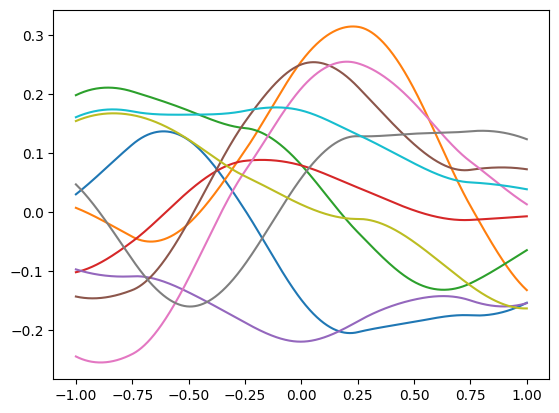

In [4]:
xx = torch.linspace(-1, 1, 1000).view(1000, 1).repeat(1, inp_ch)
basis_funcs = m.get_basis_func(xx)
result = basis_funcs.view(basis_funcs.shape[0], -1) @ m.params

for i in range(out_ch):
    plt.plot(xx[:,0].cpu(), result[:,i].detach().cpu())

    

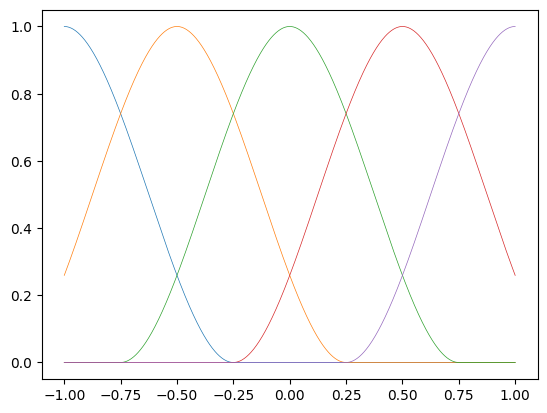

In [5]:
for i in range(0, basis_funcs.shape[2]):
    plt.plot(xx[:,0].cpu(), basis_funcs[:,0,i].detach().cpu(), lw=0.5)

In [6]:
class MLP(nn.Module):
    def __init__(self, inp, hidden, out):
        super().__init__()
        self.lin1 = nn.Linear(inp, hidden)
        self.lin2 = nn.Linear(hidden, out)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.gelu(x)
        x = self.lin2(x)
        return x

In [7]:
class KANModel(nn.Module):
    def __init__(self, layers, grid_res=3):
        super().__init__()
        lst = []
        for i, j in zip(layers[:-1], layers[1:]):
            lst.append(KAN(i,j,grid_res))
        self.model = nn.ModuleList(lst)
        
        
    def forward(self, x):
        for m in self.model:
            x = m(x)
        return x

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1000, shuffle=True, num_workers=12)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000, num_workers=12)


In [9]:
kan_model_3 = KANModel([784, 784*4, 10], 3).cuda()
kan_model_4 = KANModel([784, 784*4, 10], 4).cuda()
kan_model_5 = KANModel([784, 784*4, 10], 5).cuda()
kan_model_7 = KANModel([784, 784*4, 10], 7).cuda()
kan_model_10 = KANModel([784, 784*4, 10], 10).cuda()
mlp_model = MLP(784, 784*4, 10).cuda()

In [10]:
def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=2.0e-4, weight_decay=0)
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    for e in tqdm(range(0, 100)):
        model.train()
        loss_acc = 0
        acc_acc = 0
        bs = 0
        start_time = time.time()
        for i,b in enumerate(train_loader):

            inp, out = b
            inp = inp.cuda().view(inp.shape[0], -1)
            out = F.one_hot(out.cuda(), num_classes=10) * 2 - 1

            outm = model(inp)

            loss = F.softplus(-out * outm).mean(1)

            acc = (out.argmax(1) == outm.argmax(1)).float().sum()
            loss_acc += loss.sum()
            acc_acc += acc
            bs += inp.shape[0]

            optim.zero_grad()
            loss.mean().backward()
            optim.step()
        end_time = time.time()
        #print(f"Train Time: {end_time-start_time:.4f}")
        #print(f"Train Loss: {(loss_acc/bs).item():.4f}")
        #print(f"Train Accuracy: {(acc_acc/bs).item():.4f}")
        train_loss.append((loss_acc/bs).item())
        train_accuracy.append((acc_acc/bs).item())
        
        with torch.no_grad():
            model.eval()
            loss_acc = 0
            acc_acc = 0
            bs = 0
            start_time = time.time()
            for i,b in enumerate(test_loader):
                inp, out = b
                inp = inp.cuda().view(inp.shape[0], -1)
                out = F.one_hot(out.cuda(), num_classes=10) * 2 - 1
                outm = model(inp)
                loss = F.softplus(-out * outm).mean(1).sum()
                acc = (out.argmax(1) == outm.argmax(1)).float().sum()
                acc_acc += acc
                loss_acc += loss
                bs += inp.shape[0]
            end_time = time.time()
            #print(f"Valid Time: {end_time-start_time:.4f}")
            #print(f"Valid Loss: {(loss_acc/bs).item():.4f}")
            #print(f"Valid Accuracy: {(acc_acc/bs).item():.4f}")
            valid_loss.append((loss_acc/bs).item())
            valid_accuracy.append((acc_acc/bs).item())
            
   
    return train_loss, valid_loss, train_accuracy, valid_accuracy

In [11]:
kan_hist_3 = train(kan_model_3)
kan_hist_4 = train(kan_model_4)
kan_hist_5 = train(kan_model_5)
kan_hist_7 = train(kan_model_7)
kan_hist_10 = train(kan_model_10)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
mlp_hist = train(mlp_model)

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
skip_first = 4

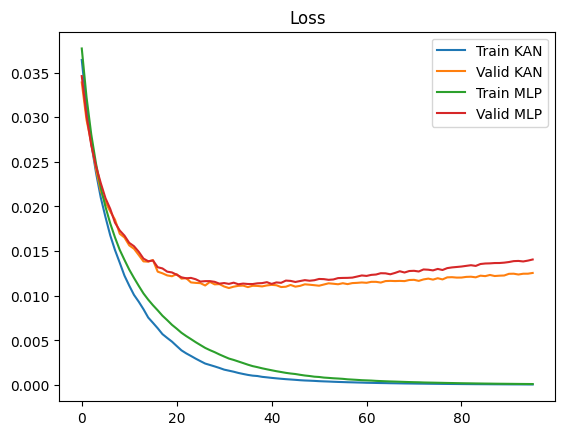

In [14]:
f, ax = plt.subplots()
ax.set_title('Loss')
ax.plot(kan_hist_4[0][skip_first:], label='Train KAN')
ax.plot(kan_hist_4[1][skip_first:], label='Valid KAN')
ax.plot(mlp_hist[0][skip_first:], label='Train MLP')
ax.plot(mlp_hist[1][skip_first:], label='Valid MLP')
ax.legend()

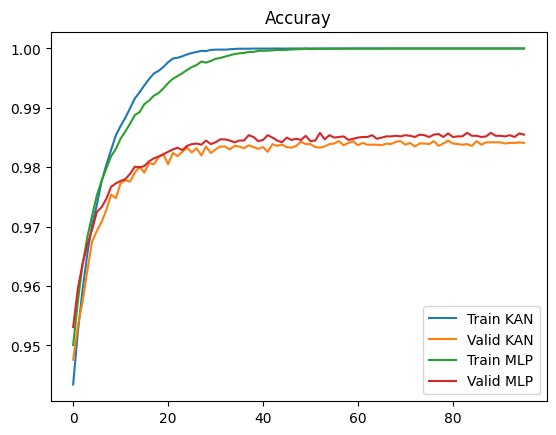

In [15]:
f, ax = plt.subplots()
ax.set_title('Accuray')
ax.plot(kan_hist_4[2][skip_first:], label='Train KAN')
ax.plot(kan_hist_4[3][skip_first:], label='Valid KAN')
ax.plot(mlp_hist[2][skip_first:], label='Train MLP')
ax.plot(mlp_hist[3][skip_first:], label='Valid MLP')
ax.legend()

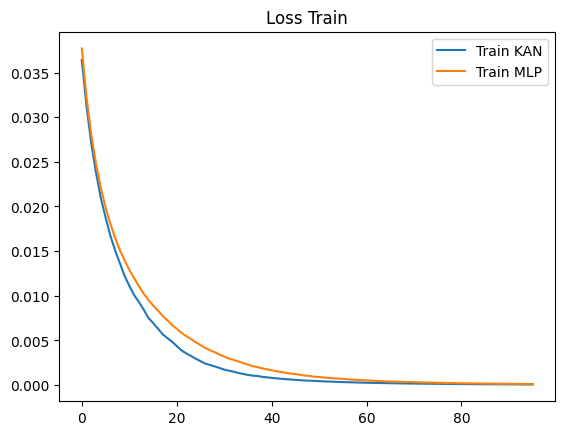

In [16]:
f, ax = plt.subplots()
ax.set_title('Loss Train')
ax.plot(kan_hist_4[0][skip_first:], label='Train KAN')
ax.plot(mlp_hist[0][skip_first:], label='Train MLP')
ax.legend()

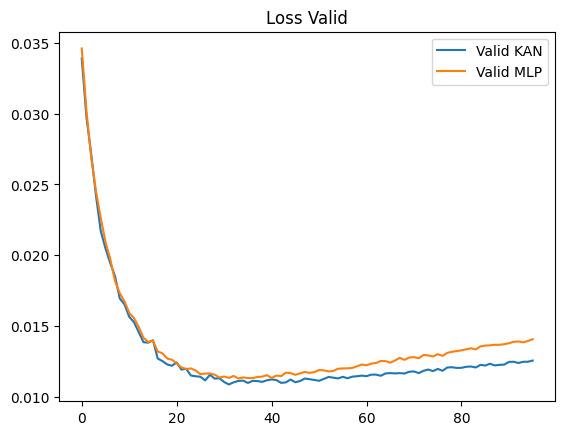

In [17]:
f, ax = plt.subplots()
ax.set_title('Loss Valid')
ax.plot(kan_hist_4[1][skip_first:], label='Valid KAN')
ax.plot(mlp_hist[1][skip_first:], label='Valid MLP')
ax.legend()

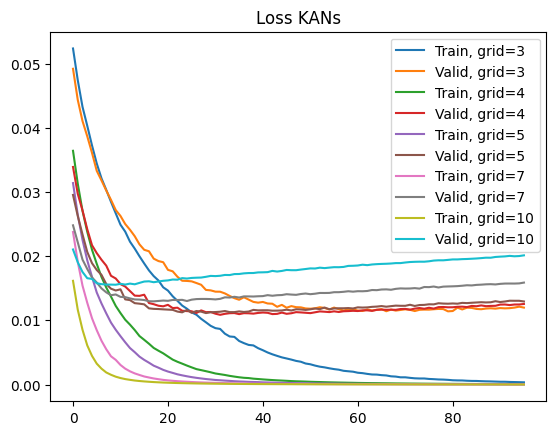

In [18]:
f, ax = plt.subplots()
ax.set_title('Loss KANs')
ax.plot(kan_hist_3[0][skip_first:], label='Train, grid=3')
ax.plot(kan_hist_3[1][skip_first:], label='Valid, grid=3')
ax.plot(kan_hist_4[0][skip_first:], label='Train, grid=4')
ax.plot(kan_hist_4[1][skip_first:], label='Valid, grid=4')
ax.plot(kan_hist_5[0][skip_first:], label='Train, grid=5')
ax.plot(kan_hist_5[1][skip_first:], label='Valid, grid=5')
ax.plot(kan_hist_7[0][skip_first:], label='Train, grid=7')
ax.plot(kan_hist_7[1][skip_first:], label='Valid, grid=7')
ax.plot(kan_hist_10[0][skip_first:], label='Train, grid=10')
ax.plot(kan_hist_10[1][skip_first:], label='Valid, grid=10')
ax.legend()

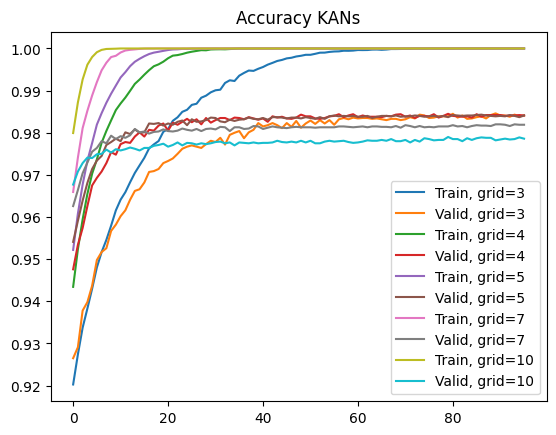

In [19]:
f, ax = plt.subplots()
ax.set_title('Accuracy KANs')
ax.plot(kan_hist_3[2][skip_first:], label='Train, grid=3')
ax.plot(kan_hist_3[3][skip_first:], label='Valid, grid=3')
ax.plot(kan_hist_4[2][skip_first:], label='Train, grid=4')
ax.plot(kan_hist_4[3][skip_first:], label='Valid, grid=4')
ax.plot(kan_hist_5[2][skip_first:], label='Train, grid=5')
ax.plot(kan_hist_5[3][skip_first:], label='Valid, grid=5')
ax.plot(kan_hist_7[2][skip_first:], label='Train, grid=7')
ax.plot(kan_hist_7[3][skip_first:], label='Valid, grid=7')
ax.plot(kan_hist_10[2][skip_first:], label='Train, grid=10')
ax.plot(kan_hist_10[3][skip_first:], label='Valid, grid=10')
ax.legend()